In [2]:
import pandas as pd
from datasets import load_from_disk

# Load local datasets
train = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/train")
val = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/validation")
test = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/test")

# Convert a sample to pandas for exploration
df = train.to_pandas()

c:\Users\Fahad's WorkStation\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Columns:", df.columns.tolist())

Columns: ['summary', 'uid', 'id', 'transcript']


In [5]:
print("\nSample row:\n", df.iloc[:2])


Sample row:
                                              summary  \
0  AS AMENDED a bill for an ordinance amending th...   
1  AS AMENDED a bill for an ordinance amending th...   

                                  uid  id  \
0  DenverCityCouncil_05012017_17-0161   0   
1  DenverCityCouncil_04102017_17-0161   1   

                                          transcript  
0  Please refrain from profane or obscene speech....  
1  An assessment has called out council bill 161 ...  


In [6]:
# Add length columns
df["transcript_length"] = df["transcript"].apply(lambda x: len(x.split()))
df["summary_length"] = df["summary"].apply(lambda x: len(x.split()))

# Show descriptive stats
print("\nTranscript vs Summary Length Stats:")
print(df[["transcript_length", "summary_length"]].describe())

# Check for missing or empty entries
print("\nMissing Transcripts:", df["transcript"].isnull().sum())
print("Missing Summaries:", df["summary"].isnull().sum())



Transcript vs Summary Length Stats:
       transcript_length  summary_length
count        5169.000000     5169.000000
mean         2964.876378       59.805765
std          5360.673012       35.663050
min            85.000000       14.000000
25%           379.000000       32.000000
50%          1036.000000       52.000000
75%          3044.000000       79.000000
max         67634.000000      217.000000

Missing Transcripts: 0
Missing Summaries: 0


In [8]:
# Length calculations
df["transcript_words"] = df["transcript"].apply(lambda x: len(x.split()))
df["summary_words"] = df["summary"].apply(lambda x: len(x.split()))
df["length_ratio"] = df["transcript_words"] / df["summary_words"]

# --- Summary stats
print("\n📊 Summary Statistics:")
print(df[["transcript_words", "summary_words", "length_ratio"]].describe())



📊 Summary Statistics:
       transcript_words  summary_words  length_ratio
count       5169.000000    5169.000000   5169.000000
mean        2964.876378      59.805765     68.461333
std         5360.673012      35.663050    138.920186
min           85.000000      14.000000      0.901734
25%          379.000000      32.000000      7.137931
50%         1036.000000      52.000000     21.117647
75%         3044.000000      79.000000     69.462963
max        67634.000000     217.000000   2444.285714


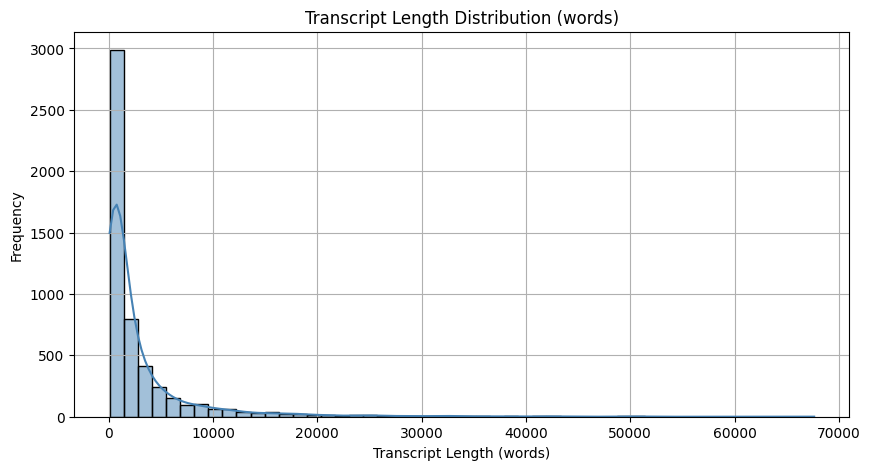

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualize transcript length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["transcript_words"], bins=50, kde=True, color="steelblue")
plt.title("Transcript Length Distribution (words)")
plt.xlabel("Transcript Length (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


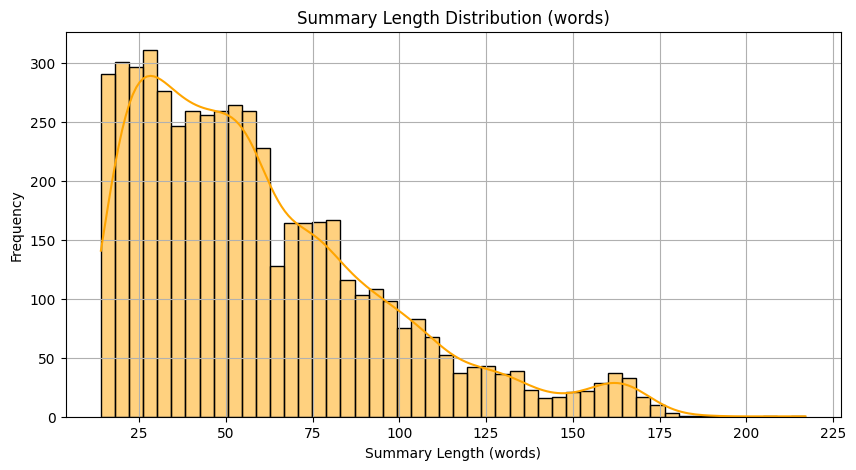

In [ ]:
# --- Visualize summary length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["summary_words"], bins=50, kde=True, color="orange")
plt.title("Summary Length Distribution (words)")
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

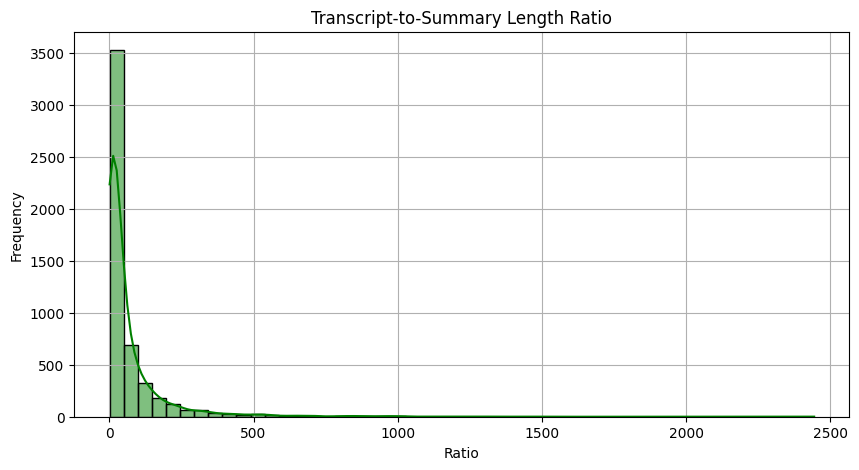

In [13]:
# --- Ratio of transcript-to-summary length
plt.figure(figsize=(10, 5))
sns.histplot(df["length_ratio"], bins=50, kde=True, color="green")
plt.title("Transcript-to-Summary Length Ratio")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

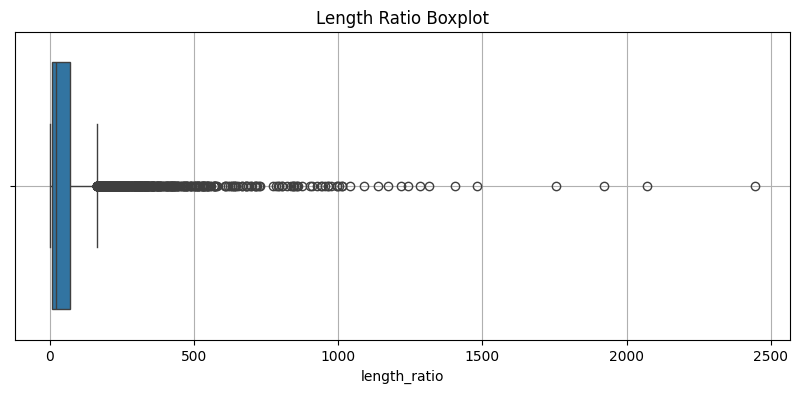

In [14]:
# --- Boxplot to check outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["length_ratio"])
plt.title("Length Ratio Boxplot")
plt.grid(True)
plt.show()


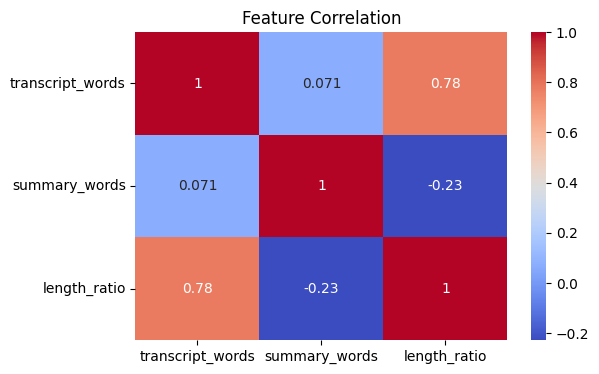

In [ ]:
# --- Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[["transcript_words", "summary_words", "length_ratio"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [16]:
# --- Inspect sample summaries
print("\n📝 Sample Summary-Transcript Pair:")
for i in range(2):
    print(f"\n--- Example {i+1} ---")
    print("Transcript (short preview):", df.iloc[i]["transcript"][:300], "...")
    print("Summary:", df.iloc[i]["summary"])


📝 Sample Summary-Transcript Pair:

--- Example 1 ---
Transcript (short preview): Please refrain from profane or obscene speech. Direct your comments to council as a whole and refrain from individual or personal attacks. Councilwoman Gilmore, will you please put Council Bill 161 on the floor? Yes, President Brooks, I move that council bill 161 as amended, be placed upon final con ...
Summary: AS AMENDED a bill for an ordinance amending the Denver Zoning Code to revise parking exemptions for pre-existing small zone lots. Approves a text amendment to the Denver Zoning Code to revise the Pre-Existing Small Zone Lot parking exemption. The Committee approved filing this bill at its meeting on 2-14-17. On 2-27-17, Council held this item in Committee to 3-20-17. Amended 3-20-17 to ensure that the parking exemption is applied for all uses. Some parking requirements are calculated based on gross floor area while others are on number of units and not explicitly for gross floor area, to further c

In [18]:
import re
from datasets import load_from_disk, DatasetDict

# Load MeetingBank
meetingbank = DatasetDict({
    "train": load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/train"),
    "validation": load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/validation"),
    "test": load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/test")
})

In [19]:
# Clean text function
def clean_text(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)                         # Normalize whitespace
    text = re.sub(r'<[^>]+>', '', text)                      # Remove HTML tags
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)              # Remove control chars
    return text

# Apply preprocessing
def preprocess_function(example):
    transcript = clean_text(example["transcript"])
    summary = clean_text(example["summary"])
    if transcript and summary:
        return {"transcript": transcript, "summary": summary}
    else:
        return None  # Drop empty ones

# Apply to all splits
for split in meetingbank:
    meetingbank[split] = meetingbank[split].filter(lambda x: x["transcript"] and x["summary"])
    meetingbank[split] = meetingbank[split].map(preprocess_function)

# Save cleaned version
meetingbank["train"].save_to_disk("data/cleaned/train")
meetingbank["validation"].save_to_disk("data/cleaned/validation")
meetingbank["test"].save_to_disk("data/cleaned/test")

print("✅ Preprocessing complete and saved to data/cleaned/")


Saving the dataset (1/1 shards): 100%|██████████| 862/862 [00:00<00:00, 45020.86 examples/s]

✅ Preprocessing complete and saved to data/cleaned/


In [1]:
from datasets import load_from_disk, DatasetDict
from transformers import LEDTokenizerFast
import os

# === Load each split individually ===
train_dataset = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/cleaned/train")
val_dataset = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/cleaned/validation")
test_dataset = load_from_disk("C:/Users/Fahad's WorkStation/Programs/PF/MeetSum/data/cleaned/test")

# === Combine into a single DatasetDict ===
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})


c:\Users\Fahad's WorkStation\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = LEDTokenizerFast.from_pretrained("allenai/led-base-16384")
tokenizer.model_max_length = 16384  # Full max length supported by LED

def tokenize_batch(example):
    # Tokenize transcripts (input)
    model_inputs = tokenizer(
        example["transcript"],
        padding="max_length",
        truncation=True,
        max_length=16384,
        return_attention_mask=True
    )

    # Tokenize summaries (labels)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["summary"],
            padding="max_length",
            truncation=True,
            max_length=256  # Summary is usually much shorter
        )["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs

tokenized_dataset = dataset.map(
    tokenize_batch,
    batched=True,
    batch_size=1,
    num_proc=1
)


Map:   0%|          | 0/5169 [00:00<?, ? examples/s]c:\Users\Fahad's WorkStation\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 862/862 [00:16<00:00, 52.84 examples/s]


In [3]:
# === Save to /data/tokenized ===
output_dir = "data/tokenized"
tokenized_dataset.save_to_disk(output_dir)

print("Tokenization complete. Saved to:", output_dir)

Saving the dataset (1/1 shards): 100%|██████████| 862/862 [00:00<00:00, 4685.43 examples/s]

Tokenization complete. Saved to: data/tokenized
